<a href="https://colab.research.google.com/github/Siahkamari/Portfolio-Optimization/blob/master/portfolio_selection_with_google_finance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
import lxml
from scipy import optimize as op
from cvxopt import solvers
from cvxopt import matrix

In [2]:
## Read data
dates = ['02/07/2022','02/18/2022']

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

## ticker_list
worksheet = gc.open('stock_list').sheet1
print(worksheet)
cells = worksheet.range('B1:AZ3')

ticker_list = []
quantity = []
quantity2 = []
for i, cell in enumerate(cells):
  if i<  len(cells)/3:
    ticker_list.append(cell.value)
  elif i < (2*len(cells))/3:
    quantity.append(cell.value)
  else:
    quantity2.append(cell.value)

pd.DataFrame(columns=np.array(ticker_list), data= np.array(quantity).reshape(1,-1), index = [dates[0]])

<Worksheet 'Sheet1' id:1867415061>


,AAPL,ABBV,AGTI,AVGO,BHF,CDW,CMS,CRAI,CSCO,EXP,...,UBA,USLM,XBIT,LKQ,MSI,UTMD,DE,DKNG,G,IT
02/07/2022,16,9,50,2,,5,,,20,,...,50,,None,None,None,None,None,None,None,None


In [3]:
def get_ticker_data(ticker, silent=False):

  worksheet = gc.open('gf_data').sheet1

  cell = worksheet.range('C3:C4')
  cell[1].value = ticker
  worksheet.update_cells(cell)

  # get_all_values gives a list of rows.
  rows = worksheet.get_all_values()

  # Convert to a DataFrame and render.
  import pandas as pd
  df = pd.DataFrame.from_records(rows)
  
  # Print summary
  df_summary = df.iloc[:8,:3]

  df_today = pd.DataFrame(np.array([datetime.datetime.strptime(df_summary.iloc[1,2],'%m/%d/%Y'),\
                                  df_summary.iloc[4,2]]).reshape(1,-1),\
                        columns=['Date','Close'])

  if not silent:
    display(df_summary)


  # Read historical
  df_prices = df.iloc[8:,:3]
  df_prices.columns = df_prices.iloc[0]
  df_prices = df_prices.drop(df_prices.index[0])
  # display(df_prices.head())
  df_prices = df_prices.append(df_today)

  df_prices['Date'] = pd.to_datetime(df_prices['Date'])
  df_prices['Close'] = df_prices['Close'].astype('float32')


  df_prices['log_Close'] = np.log(df_prices['Close'].values)
  # df_prices['Volume'] = df_prices['Volume'].astype('int')
  df_prices['Close_l01'] = df_prices['Close'].shift(1).fillna(method='bfill')
  df_prices['changepct'] = (df_prices['Close']-df_prices['Close_l01'])/df_prices['Close_l01']
  df_prices['log_growth'] = np.log(df_prices['Close']) - np.log(df_prices['Close']).iloc[0]
  df_prices['dayofweek'] = df_prices['Date'].dt.dayofweek.astype('str')
  df_prices['day'] = df_prices['Date'].dt.day
  df_prices['week'] = df_prices['Date'].dt.isocalendar().week
  df_prices = df_prices.drop(columns=['Close_l01'])

  if not silent:
    display(df_prices.tail())
    fig = plt.figure(figsize=(25,10))
    ax = fig.add_subplot(1 ,1, 1)
    df_prices.set_index('Date').log_growth.plot(ax=ax, label=ticker)
    ax.legend()
    ax.set_ylabel('log_growth')


  return df_summary, df_prices

,0,1,2
0,,,
1,,end_date,06/25/2022
2,,start_date,02/07/2022
3,,ticker,THC
4,,price,58.24
5,,marketcap,6.273752756
6,,pe,6.65
7,,datadelay,0


,Date,Close,Volume,log_Close,changepct,log_growth,dayofweek,day,week
101,2022-06-21 16:00:00,52.150002,1514786,3.954124,-0.015109,-0.294371,1,21,25
102,2022-06-22 16:00:00,54.279999,1750161,3.994156,0.040844,-0.254339,2,22,25
103,2022-06-23 16:00:00,55.750000,2792417,4.020877,0.027082,-0.227618,3,23,25
104,2022-06-24 16:00:00,58.240002,14737259,4.064572,0.044664,-0.183923,4,24,25
0,2022-06-25 00:00:00,58.240002,NaN,4.064572,0.000000,-0.183923,5,25,25


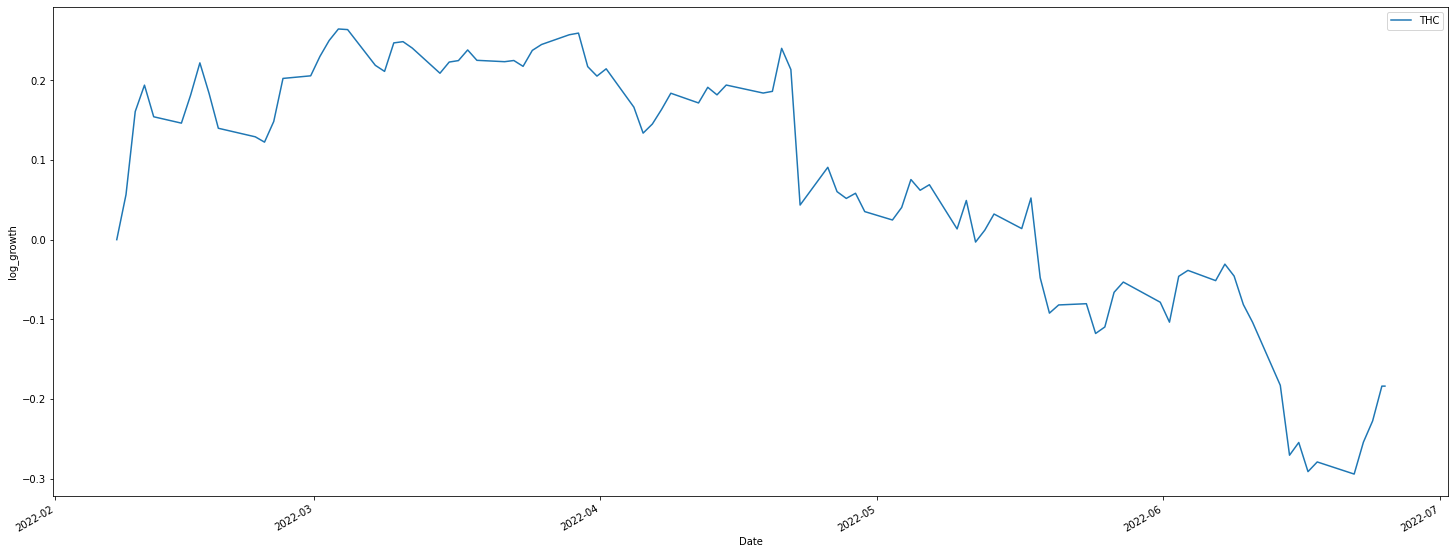

In [4]:
df_summary, df_prices = get_ticker_data('THC')

In [14]:
n = len(ticker_list)
df_all_prices = pd.DataFrame(columns=['Date'])
for i, ticker in enumerate(ticker_list):
    try:
      _, df_prices = get_ticker_data(ticker, silent=True)
      df_prices = df_prices[['Date','Close']].rename(columns={'Close':ticker})
      df_all_prices =  df_all_prices.merge(df_prices, on='Date', how='outer') 
    except:
        print("failed to download ",ticker)

T = df_all_prices.shape[0]

In [7]:
def pfe(df_all_prices, x_0, T_0, cut_off = 0.01):

  T = df_all_prices.shape[0]
  n = df_all_prices.shape[1] -1

  # initialization
  f_digit = np.zeros(T)

  sum_g_tild = np.zeros(n)
  sum_g_tild_w = np.zeros(n)
  # iterations
  for t in range(T-1):
      w = sum_g_tild /(t+T_0/2)*(1+sum_g_tild_w)
      x =  x_0 * np.maximum(w, 0)
      if np.sum(x) > 0:
          x = x / np.sum(x)
      else:
          x = x_0

      p_t = df_all_prices.iloc[t,1:]
      p_t01 = df_all_prices.iloc[t+1,1:]
      r = np.array( (p_t01/p_t).fillna(1).values)
      grad = r/np.dot(x, r)

      g_tild = grad - np.dot(grad, x)
      g_tild[w<0] = np.maximum(g_tild[w<0], 0)

      sum_g_tild += g_tild
      sum_g_tild_w += g_tild*w
      if t == 0:
        f_digit[0] = 0
      else:
        # digitalized wealth
        present = x> cut_off
        x_digit = x[present]
        r_digit = r[present]
        f_digit[t] = -np.log(np.dot(x_digit,r_digit)/sum(x_digit))

  return x, np.cumsum(-f_digit[1:])

In [8]:
def project(y, A):
  n = y.size

  P = matrix(A, tc='d')
  q = matrix(-2*np.matmul(y, A), tc='d')
  G = matrix(-np.eye(n), tc='d')
  h = matrix(np.zeros(n), tc='d')
  A = matrix(np.ones([1,n]), tc='d')
  b = matrix([1], tc='d')

  solvers.options['show_progress'] = False
  sol = solvers.qp(P,q,G,h,A,b)
  return np.array(sol['x']).reshape(-1)

def ons(df_all_prices):
  T = df_all_prices.shape[0]
  n = df_all_prices.shape[1] -1
  # parameters:
  alpha = 0.5

  # algorithm
  G = np.sqrt(n)/alpha
  gamma = 1/8/G
  epsilon = 1/gamma**2

  # Initialization
  A = epsilon*np.eye(n)
  f = np.zeros(T)

  x = np.ones(n)/n
  # iterations
  for t in range(T-1):
    r = np.array((df_all_prices.iloc[t+1,1:]/df_all_prices.iloc[t,1:]).fillna(1).values)
    grad = - r/np.dot(x, r)
    A = A + np.outer(grad, grad)
    y = x - 1/gamma * np.linalg.solve(A, grad)
    x = project(y, A)

    # log wealth
    f[t] = - np.log(np.dot(x,r))


  return x, np.cumsum(-f[1:])

In [9]:
def portfolio_plot(x,tickers,cut_off,ax1):
  biggest = np.argsort(x)
  sizes = []
  labels = []
  for i in biggest[::-1]:
    if x[i] > cut_off:
      sizes.append(x[i]*100)
      labels.append(tickers[i])
  ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
  ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
  return ax1

cost_basis = 47556.50022602081
current price x_0 36632.80035638809
PMF assets =  37910.74897630766
ONS assets =  32272.133030454268
PFE(PFE,ONS) =  31497.368733881576


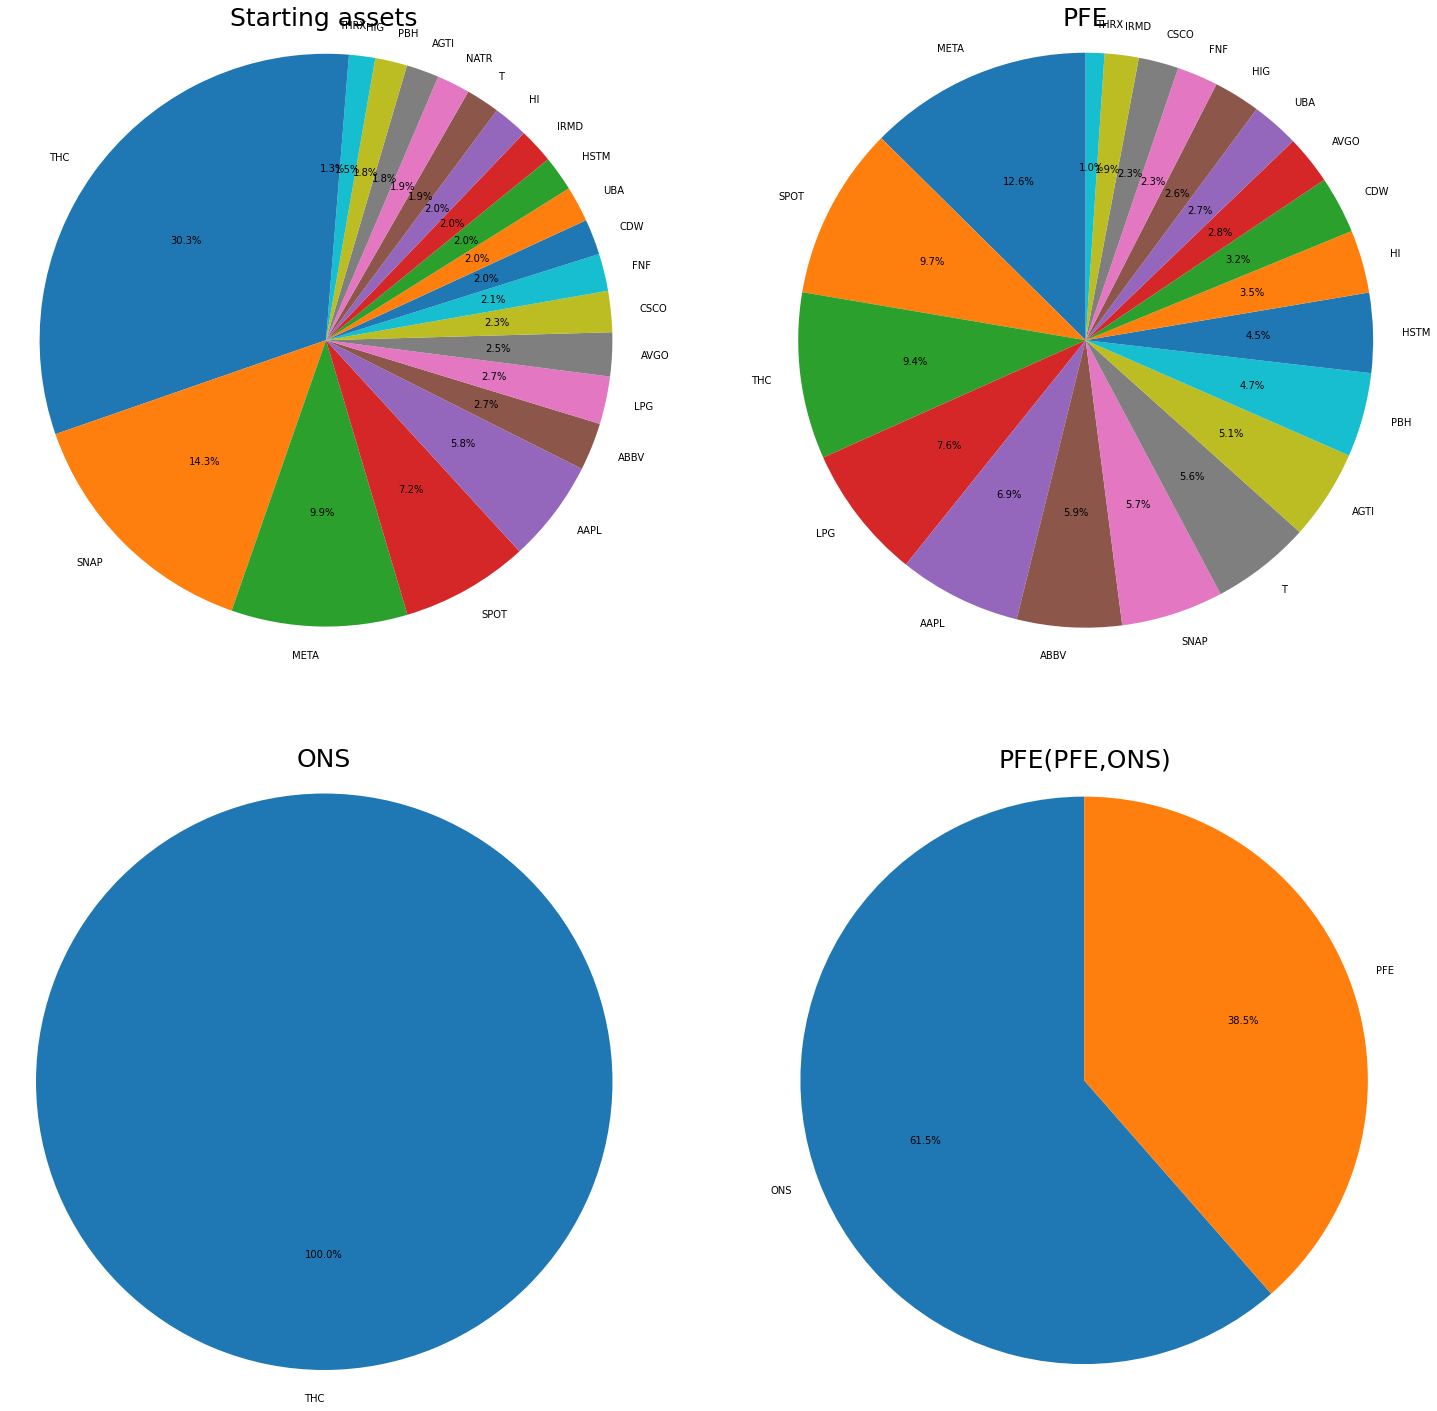

In [11]:
fig1, ax1 = plt.subplots(2,2)
fig1.set_size_inches(25, 25)

cut_off = 0.01
T_0 = 100

# Current Portfolio
for i, n in enumerate(quantity):
  if n == '':
    quantity[i] = 0
  if n == 'None':
    quantity[i] = 0
quantity = np.array(quantity).astype(int)
cost_basis = quantity*df_all_prices.iloc[0,1:]
print('cost_basis =', np.sum(cost_basis))
print('current price x_0', np.sum(quantity*df_all_prices.iloc[-1,1:]))
x_0 =  cost_basis/np.sum(cost_basis)
ax1[0,0] = portfolio_plot(x_0,ticker_list,cut_off,ax1[0,0])
ax1[0,0].set_title('Starting assets', {'fontsize': 25})

# Parameter Free Expert
x, log_wealth_expert = pfe(df_all_prices, x_0, T_0=T_0, cut_off=cut_off)
ax1[0,1] = portfolio_plot(x,ticker_list,cut_off,ax1[0,1])
ax1[0,1].set_title('PFE', {'fontsize': 25})
print('PMF assets = ', np.exp(log_wealth_expert[-1])*np.sum(cost_basis))

# ONS 
x, log_wealth_ons = ons(df_all_prices)
ax1[1,0] = portfolio_plot(x,ticker_list,cut_off,ax1[1,0])
ax1[1,0].set_title('ONS', {'fontsize': 25})
print('ONS assets = ', np.exp(log_wealth_ons[-1])*np.sum(cost_basis))

# ONS + Parameter Free Expert
my_etf = ['ONS','PFE']
alg1 = np.exp(log_wealth_expert).reshape(-1,1)
alg2 = np.exp(log_wealth_ons).reshape(-1,1)
etf = np.concatenate((df_all_prices['Date'].dt.day.values.reshape(-1,1),
                      np.append(np.array(1).reshape(-1,1),alg1, axis=0),
                      np.append(np.array(1).reshape(-1,1),alg2, axis=0)), axis = 1)
df_etf = pd.DataFrame(data = etf, columns=['Date']+my_etf)

x , log_wealth_expert_ons = pfe(df_etf, [0.5,0.5], T_0)
ax1[1,1] = portfolio_plot(x, my_etf, cut_off, ax1[1,1])
ax1[1,1].set_title('PFE(PFE,ONS)', {'fontsize': 25})
print('PFE(PFE,ONS) = ', np.exp(log_wealth_expert_ons[-1])*np.sum(cost_basis))

plt.show()

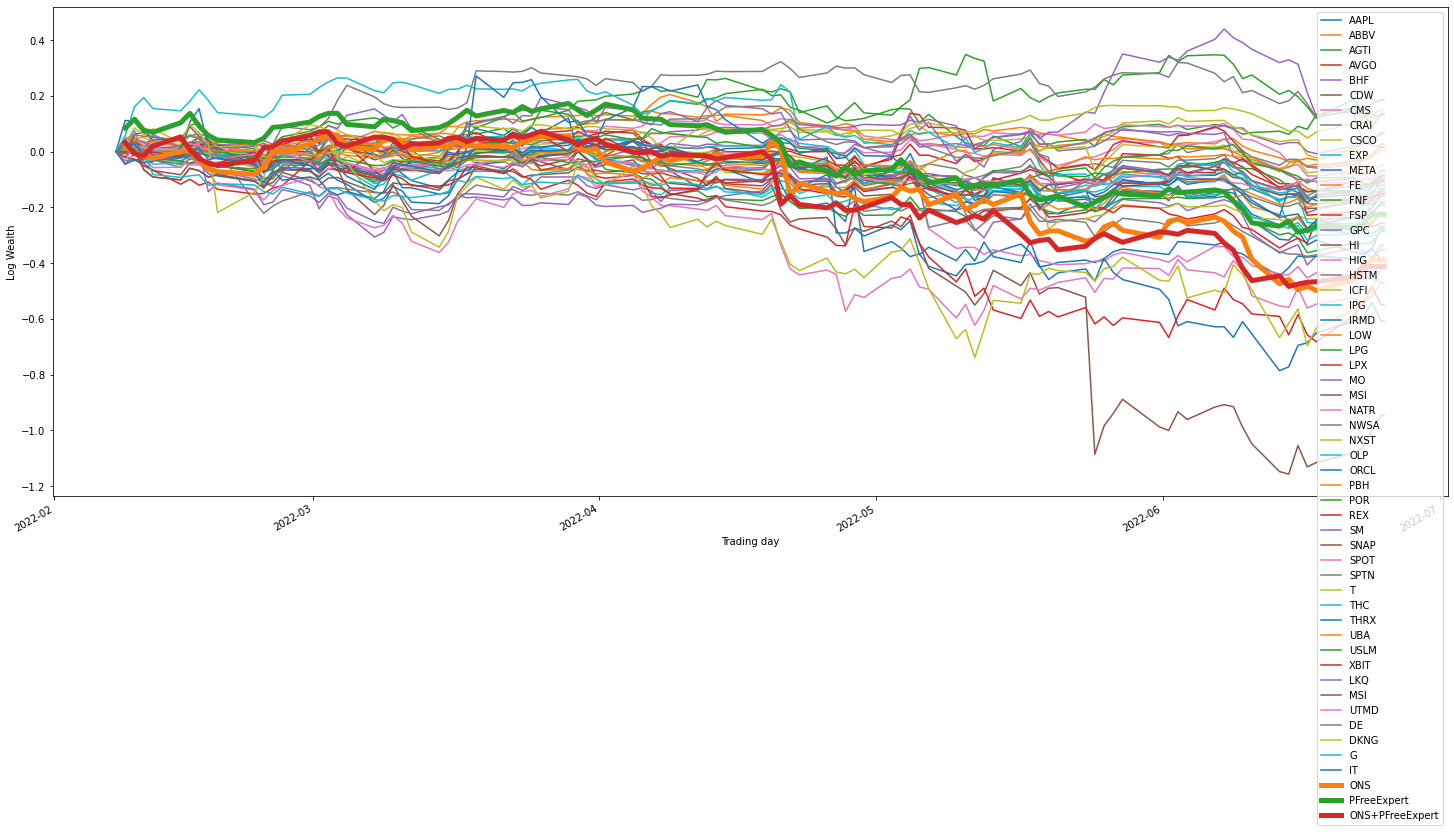

In [13]:
## Visualization
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1 ,1, 1)
for ticker in ticker_list:
  _, df_prices = get_ticker_data(ticker, silent=True)
  df_prices.set_index('Date').log_growth.plot(ax=ax, label=ticker)
ax.legend();
ax.set_ylabel('log_growth')


df_ons = pd.DataFrame(data=log_wealth_ons, index=df_all_prices['Date'][1:], columns=['ONS'])
df_pmf = pd.DataFrame(data=log_wealth_expert, index=df_all_prices['Date'][1:], columns=['PFreeExpert'])
df_pmfons = pd.DataFrame(data=log_wealth_expert_ons, index=df_all_prices['Date'][1:], columns=['ONS+PFreeExpert'])
df_ons.plot(ax = ax, linewidth=5)
df_pmf.plot(ax = ax, linewidth=5)
df_pmfons.plot(ax = ax, linewidth=5)

ax.legend()
ax.set_xlabel('Trading day')
ax.set_ylabel('Log Wealth')
plt.show()